# Make a Dataset

In [1]:
import matplotlib.pyplot as plt
import imgaug as ia
ia.seed(1)
%matplotlib inline
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from imgaug import augmenters as iaa 
import imageio
import pandas as pd
import numpy as np
import re
import os
import glob
import xml.etree.ElementTree as ET
import shutil

In [50]:
# load images as NumPy arrays and append them to images list
images = []
for file in glob.glob('images/*.jpg') + glob.glob('images/*.JPG'):
    images.append(imageio.imread(file))
print('There are {} images'.format(len(images)))


/var/folders/z_/b810_k3d3psf_5j00kyq1q0m0000gn/T/ipykernel_17178/2563518038.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file))


There are 108 images


In [4]:
def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     1,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [46]:
labels_df = xml_to_csv('annotations/')
labels_df.to_csv(('labels.csv'), index=None)

In [19]:
grouped = labels_df.groupby('filename')
group_df = grouped.get_group('IMG_5219.jpg')
group_df = group_df.reset_index()
group_df = group_df.drop(['index'], axis=1)
group_df

,filename,width,height,class,xmin,ymin,xmax,ymax
0,IMG_5219.jpg,3024,4032,1,1135,2527,1301,2656
1,IMG_5219.jpg,3024,4032,1,1310,2529,1457,2660
2,IMG_5219.jpg,3024,4032,1,1468,2544,1628,2673
3,IMG_5219.jpg,3024,4032,1,1637,2544,1810,2673
4,IMG_5219.jpg,3024,4032,1,1808,2560,1959,2680


In [23]:
bb_array = group_df.drop(['filename', 'width', 'height', 'class'], axis=1).values
bb_array


array([[1135, 2527, 1301, 2656],
       [1310, 2529, 1457, 2660],
       [1468, 2544, 1628, 2673],
       [1637, 2544, 1810, 2673],
       [1808, 2560, 1959, 2680]])

In [10]:
height_resize = iaa.Sequential([iaa.Resize({'height': 600, 'width': 'keep-aspect-ratio'})])
width_resize = iaa.Sequential([iaa.Resize({'height': 'keep-aspect-ratio', 'width': 600})])

In [11]:
def bbs_obj_to_df(bbs_object):
    bbs_array = bbs_object.to_xyxy_array()
    df_bbs = pd.DataFrame(bbs_array, columns = ['xmin', 'ymin', 'xmax', 'ymax'])
    return df_bbs

In [38]:
def resize_imgaug(df, images_path, aug_images_path, image_prefix):
    aug_bbs_xy = pd.DataFrame(columns = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax'])
    grouped = df.groupby('filename')
    for filename in df['filename'].unique():
        group_df = grouped.get_group(filename)
        group_df = group_df.reset_index()
        group_df = group_df.drop(['index'], axis=1)
    
        if group_df['width'].unique() < 600 and group_df['height'].unique() < 600:
            aug_bbs_xy = pd.concat([aug_bbs_xy, aug_df])
        else:
            image = imageio.imread(images_path+filename)
            bb_array = group_df.drop(['filename', 'width', 'height', 'class'], axis=1).values
            bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array, shape = image.shape)
            if group_df['height'].unique()[0] >= group_df['width'].unique()[0] and group_df['height'].unique()[0] > 600:
                image_aug, bbs_aug = height_resize(image=image, bounding_boxes=bbs)
            elif group_df['width'].unique()[0] > group_df['height'].unique()[0] and group_df['width'].unique()[0] > 600:
                image_aug, bbs_aug = width_resize(image=image, bounding_boxes=bbs)
            imageio.imwrite(aug_images_path+image_prefix+filename, image_aug)
            info_df = group_df.drop(['xmin', 'ymin', 'xmax', 'ymax'], axis=1)
            for index, _ in info_df.iterrows():
                info_df.at[index, 'width'] = image_aug.shape[1]
                info_df.at[index, 'height'] = image_aug.shape[0]
            info_df['filename'] = info_df['filename'].apply(lambda x: image_prefix+x)
            bbs_df = bbs_obj_to_df(bbs_aug)
            aug_df = pd.concat([info_df, bbs_df], axis=1)
            aug_bbs_xy = pd.concat([aug_bbs_xy, aug_df])
    aug_bbs_xy = aug_bbs_xy.reset_index()
    aug_bbs_xy = aug_bbs_xy.drop(['index'], axis=1)
    return aug_bbs_xy

In [39]:
resized_images_df = resize_imgaug(labels_df, 'images/', 'aug_images/', 'resized_')
resized_images_df

/var/folders/z_/b810_k3d3psf_5j00kyq1q0m0000gn/T/ipykernel_17178/2952308537.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(images_path+filename)
/var/folders/z_/b810_k3d3psf_5j00kyq1q0m0000gn/T/ipykernel_17178/2952308537.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(images_path+filename)
/var/folders/z_/b810_k3d3psf_5j00kyq1q0m0000gn/T/ipykernel_17178/2952308537.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this wa

,filename,width,height,class,xmin,ymin,xmax,ymax
0,resized_IMG_5225.jpg,450,600,1,112.648811,258.928558,150.595245,284.077393
1,resized_IMG_5225.jpg,450,600,1,152.976196,259.226196,183.035721,284.672638
2,resized_IMG_5225.jpg,450,600,1,184.672623,258.928558,217.113098,283.333313
3,resized_IMG_5225.jpg,450,600,1,219.047607,256.547638,251.488098,281.101196
4,resized_IMG_5225.jpg,450,600,1,252.827377,256.547638,280.952393,277.827362
5,resized_IMG_5219.jpg,450,600,1,168.898804,376.041656,193.601196,395.238098
6,resized_IMG_5219.jpg,450,600,1,194.940475,376.339294,216.815475,395.833313
7,resized_IMG_5219.jpg,450,600,1,218.452377,378.571411,242.261887,397.767853
8,resized_IMG_5219.jpg,450,600,1,243.601196,378.571411,269.345215,397.767853
9,resized_IMG_5219.jpg,450,600,1,269.047607,380.952393,291.517853,398.809540


In [42]:
resized_images_df.to_csv('labels.csv', index=False)

/var/folders/z_/b810_k3d3psf_5j00kyq1q0m0000gn/T/ipykernel_17178/2808333291.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread('aug_images/resized_IMG_5219.jpg')


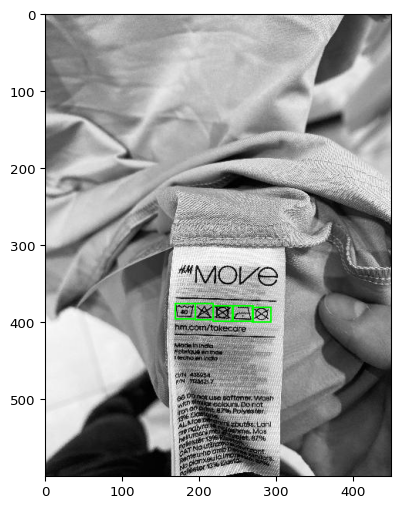

In [45]:
grouped = resized_images_df.groupby('filename')
group_df = grouped.get_group('resized_IMG_5219.jpg')
group_df = group_df.reset_index()
group_df = group_df.drop(['index'], axis=1)
bb_array = group_df.drop(['filename', 'width', 'height', 'class'], axis=1).values
image = imageio.imread('aug_images/resized_IMG_5219.jpg')
bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array, shape=image.shape)
ia.imshow(bbs.draw_on_image(image, size=2))

Resizing All Images in /image directory

In [68]:
for idx, file in enumerate(glob.glob('images/*.jpg') + glob.glob('images/*.JPG')):
    if images[idx].shape[0] >= images[idx].shape[1] and images[idx].shape[0] > 600:
        image_aug = height_resize(image = images[idx])
    else:
        image_aug = width_resize(image = images[idx])
    imageio.imwrite('aug_images/' + file[7:-4] + '.jpg', image_aug)
  